In [1]:
# GPU selection
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 35 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.3   # data for validation (not used in training)

In [3]:
import numpy as np
import re, sys, csv, pickle
from tqdm import tqdm_notebook

from keras import regularizers, initializers, optimizers, callbacks
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras.models import Model
from keras import backend as K

Using TensorFlow backend.


In [4]:
texts = []   # empty list for model input: the movie reviews
labels = []  # empty lists model output: sentiment labels

data = open("../datasets/quote.tok.gt9.5000", "r", errors='ignore') 
for line in tqdm_notebook(data, total=5000): 
    texts.append(str(line).rstrip('\n').strip())
    labels.append(int(1)) # subjective

In [5]:
data = open("../datasets/plot.tok.gt9.5000", "r") 
for line in tqdm_notebook(data, total=5000): 
    texts.append(str(line).rstrip('\n').strip())
    labels.append(int(0)) # objective

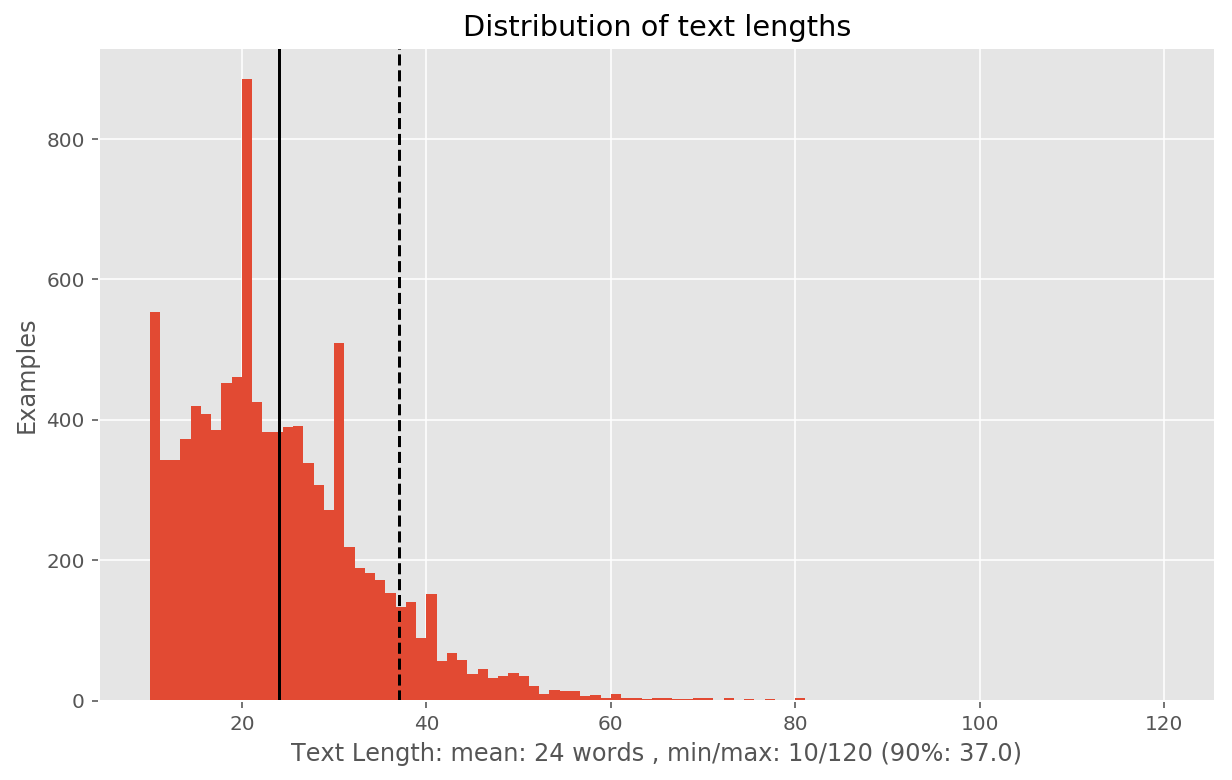

In [6]:
import  matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.style.use('ggplot')
lengths = np.array([len(row.split(" ")) for row in texts])
summary = "mean: "+str(int(np.mean(lengths)))+" words , min/max: "+str(np.min(lengths))+"/"+str(np.max(lengths))+" (90%: "+ str(round(np.percentile(lengths, 90), 2)) + ")"
plt.figure(1, figsize=(10,6))
plt.hist(lengths, bins='auto')
plt.title("Distribution of text lengths")
plt.xlabel("Text Length: " + summary); plt.ylabel("Examples")
plt.axvline(np.mean(lengths), ls="-", color="k")
plt.axvline(np.percentile(lengths, 90), ls="--", color="k")
plt.show()

In [7]:
print("Sample subjective:", texts[0], labels[0])
print("Sample objective:", texts[9000], labels[9000])

Sample subjective: smart and alert , thirteen conversations about one thing is a small gem . 1
Sample objective: atlantic city serenade is about the price we pay for the choices we make in the quest for power over our own inner demons . 0


In [8]:
MAX_SEQUENCE_LENGTH = 20
VALIDATION_SPLIT = 0.3
EMBEDDING_DIM = 100
GLOVE_DIR = "../glove/glove.6B."+str(EMBEDDING_DIM)+"d.txt"

In [9]:
tokenizer = Tokenizer(num_words=2e6)
tokenizer.fit_on_texts(texts)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("[i] Saved word tokenizer to file: tokenizer.pickle")

[i] Saved word tokenizer to file: tokenizer.pickle


In [10]:
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

word_index = tokenizer.word_index
print('[i] Found %s unique tokens.' % len(word_index))

[i] Found 22229 unique tokens.


In [11]:
sequences = tokenizer.texts_to_sequences(texts)

data = pad_sequences(sequences, padding='post', maxlen=(MAX_SEQUENCE_LENGTH))
labels = to_categorical(np.asarray(labels))
print('[+] Shape of data tensor:', data.shape)
print('[+] Shape of label tensor:', labels.shape)

[+] Shape of data tensor: (10000, 20)
[+] Shape of label tensor: (10000, 2)


In [12]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

print('[i] Number of entries in each category:')
print("[+] Training:\n",y_train.sum(axis=0))
print("[+] Validation:\n",y_val.sum(axis=0))

[i] Number of entries in each category:
[+] Training:
 [3523. 3477.]
[+] Validation:
 [1477. 1523.]


In [13]:
print("Sentence input" , texts[0])
print(" ")
print("One-hot label", labels[0])

Sentence input smart and alert , thirteen conversations about one thing is a small gem .
 
One-hot label [1. 0.]


In [14]:
embeddings_index = {}
f = open(GLOVE_DIR)
print("[i] Loading GloVe from:",GLOVE_DIR,"...",end="")
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

[i] Loading GloVe from: ../glove/glove.6B.100d.txt ...

In [15]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences = embedding_layer(sequence_input)

In [16]:
l_conv_3 = Conv1D(filters=256,kernel_size=3,activation='relu')(embedded_sequences)
l_conv_3 = Dropout(0.5)(l_conv_3)

l_conv_5 = Conv1D(filters=256,kernel_size=5,activation='relu')(embedded_sequences)
l_conv_5 = Dropout(0.5)(l_conv_5)

l_conv_7 = Conv1D(filters=256,kernel_size=7,activation='relu')(embedded_sequences)
l_conv_7 = Dropout(0.5)(l_conv_7)

l_conv = Concatenate(axis=1)([l_conv_3, l_conv_5, l_conv_7])

In [17]:
l_pool = MaxPooling1D(2)(l_conv)
l_drop = Dropout(0.5)(l_pool)
l_flat = Flatten()(l_drop)
l_dense = Dense(32, activation='relu')(l_flat)
preds = Dense(2, activation='softmax')(l_dense)

In [18]:
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['acc'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20, 100)      2223000     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 18, 256)      77056       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 16, 256)      128256      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_3 (

In [19]:
print("Training Progress:")
model_log = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                               epochs=20, batch_size=64)

Training Progress:
Train on 7000 samples, validate on 3000 samples
Epoch 1/20
7000/7000 [==============================] - 3s 365us/step - loss: 0.4592 - acc: 0.7797 - val_loss: 0.3239 - val_acc: 0.8657
Epoch 2/20
7000/7000 [==============================] - 1s 119us/step - loss: 0.2937 - acc: 0.8741 - val_loss: 0.2856 - val_acc: 0.8863
Epoch 3/20
7000/7000 [==============================] - 1s 105us/step - loss: 0.2396 - acc: 0.9021 - val_loss: 0.2797 - val_acc: 0.8907
Epoch 4/20
7000/7000 [==============================] - 1s 110us/step - loss: 0.2155 - acc: 0.9154 - val_loss: 0.2586 - val_acc: 0.8940
Epoch 5/20
7000/7000 [==============================] - 1s 127us/step - loss: 0.1897 - acc: 0.9219 - val_loss: 0.2542 - val_acc: 0.8953
Epoch 6/20
7000/7000 [==============================] - 1s 102us/step - loss: 0.1712 - acc: 0.9356 - val_loss: 0.2486 - val_acc: 0.9010
Epoch 7/20
7000/7000 [==============================] - 1s 110us/step - loss: 0.1519 - acc: 0.9436 - val_loss: 0.2486

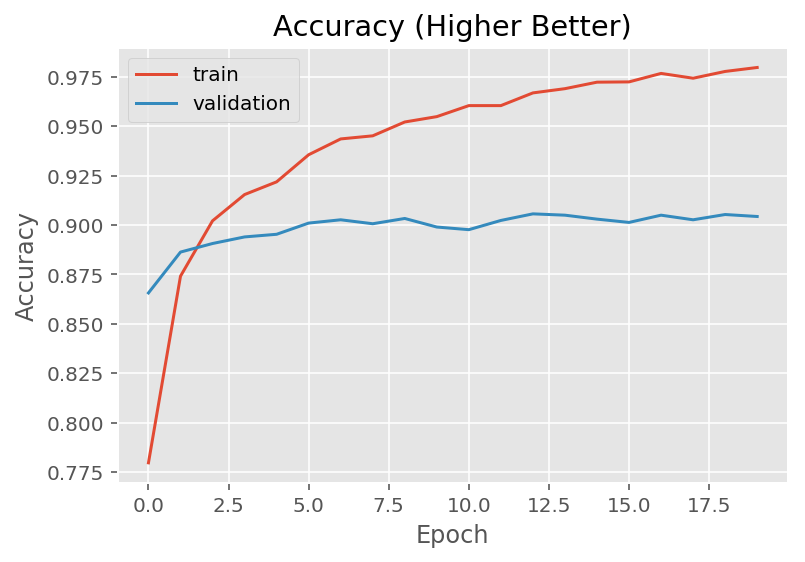

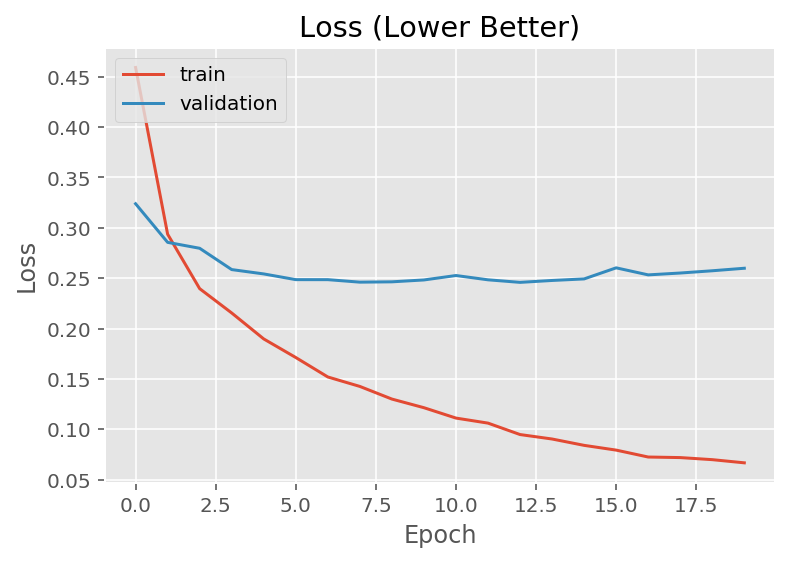

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(model_log.history['acc'])
plt.plot(model_log.history['val_acc'])
plt.title('Accuracy (Higher Better)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(model_log.history['loss'])
plt.plot(model_log.history['val_loss'])
plt.title('Loss (Lower Better)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

classes = ["subjective", "objective"]

In [22]:
Y_test = np.argmax(y_val, axis=1) # Convert one-hot to index
y_pred = model.predict(x_val)
y_pred_class = np.argmax(y_pred,axis=1)
print(classification_report(Y_test, y_pred_class, target_names=classes))

             precision    recall  f1-score   support

 subjective       0.90      0.91      0.90      1477
  objective       0.91      0.90      0.91      1523

avg / total       0.90      0.90      0.90      3000



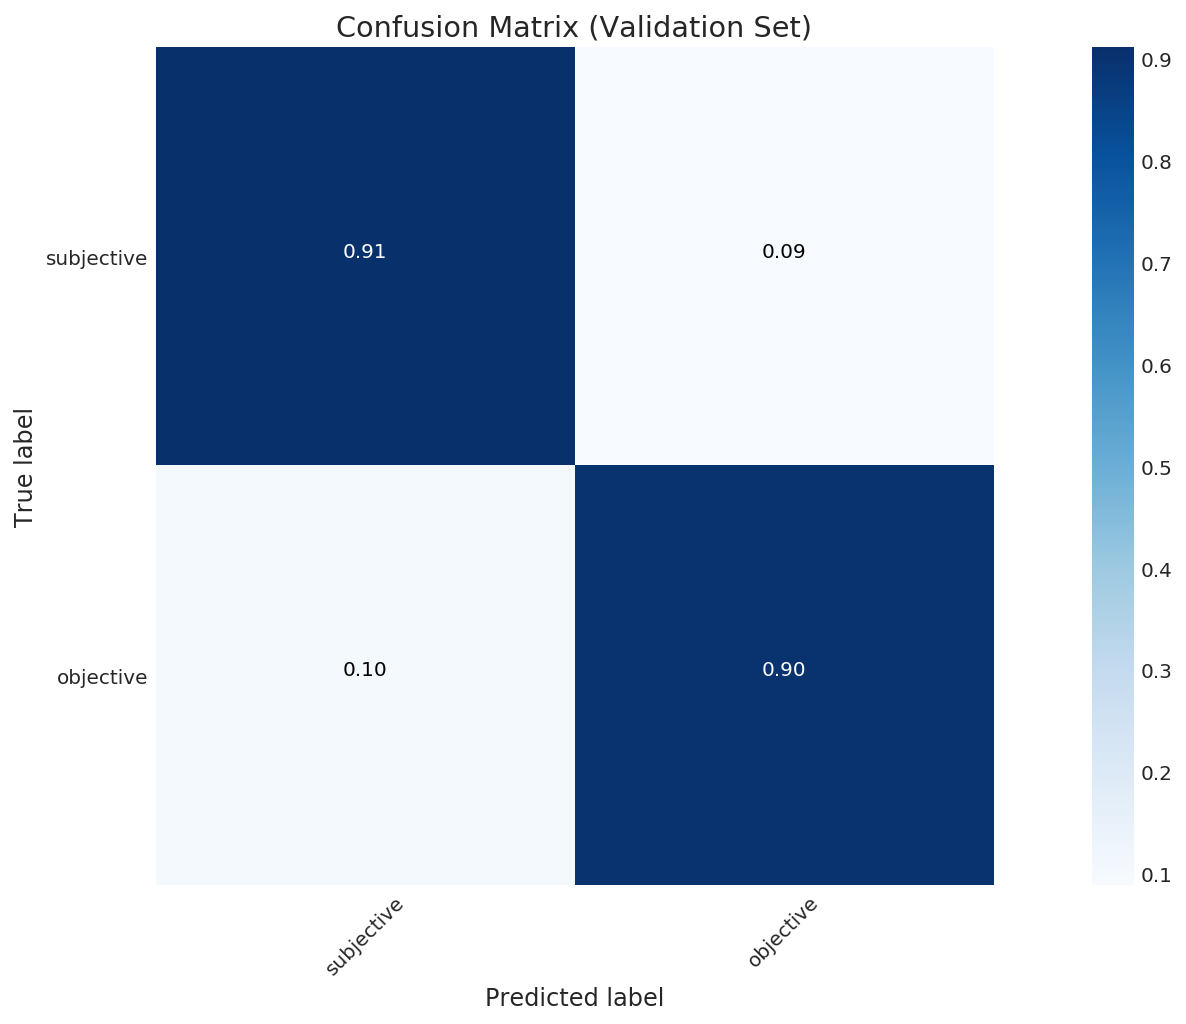

In [23]:
plt.style.use('seaborn-dark')
def plot_confusion_matrix(cm, labels,
                          normalize=True,
                          title='Confusion Matrix (Validation Set)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(14,7))
cnf_matrix = confusion_matrix(Y_test, y_pred_class)
plot_confusion_matrix(cnf_matrix, labels=classes)

In [24]:
model.save_weights("subjectivity.h5")